# Ke and Ce implementation

This notebook implements the 2x2 stiffness-like matrix Ke and the 2x2 damping-like matrix Ce from the formulas provided.

We implement a function `compute_ke_ce(eps, fc=1.0)` which returns (Ke, Ce) as NumPy arrays and performs basic domain checks.

Assumptions / notes:
- The user-provided formulas are implemented as described. For one ambiguous fraction in the `avv` term we used the interpretation where the factor `32 eps^2 (1+eps^2)` is divided by `(1 - eps^2)`. If you intended a different placement of parentheses, tell me and I'll adjust.
- The valid range for `eps` is 0 < |eps| < 1 to avoid division-by-zero or sqrt of a negative.

## Background on Hydrodynamic Bearings and Stiffness/Damping Matrices

The stiffness-like matrix $K_e$ and damping-like matrix $C_e$ are derived from the behavior of hydrodynamic bearings under certain assumptions. These bearings, which support rotating shafts, rely on a thin film of lubricant to carry loads and reduce friction. The derivation assumes:

- Laminar flow and applicability of Reynolds's equation.
- A very short bearing (length-to-diameter ratio $L/D \ll 1$).
- Constant lubricant properties and steady operating conditions.
- No shaft tilt within the bearing.

### Key Equations

The force components on the journal due to the bearing are expressed as:

$$
\begin{aligned}
    f_r &= -\frac{D \eta L^3 \varepsilon^2}{2 c^2 (1 - \varepsilon^2)^2}, \\
    f_t &= -\frac{\pi D \eta L^3 \varepsilon}{8 c^2 (1 - \varepsilon^2)^{3/2}},
\end{aligned}
$$

where $\eta$ is the lubricant viscosity, $\varepsilon$ is the eccentricity, $c$ is the radial clearance, and $L$ and $D$ are the bearing length and diameter, respectively. The resultant force magnitude $f$ is:

$$
    f = \frac{\pi D \eta L^3 \varepsilon}{8 c^2 (1 - \varepsilon^2)} \sqrt{\left(\frac{16}{\pi^2} - 1\right) \varepsilon^2 + 1}.
$$

### Stiffness and Damping Matrices

For small displacements, the force-displacement relationship can be linearized, leading to the stiffness and damping matrices:

$$
K_e = \frac{f}{c} \begin{bmatrix}
    a_{uu} & a_{uv} \\
    a_{vu} & a_{vv}
\end{bmatrix}, \quad
C_e = \frac{f}{c \Omega} \begin{bmatrix}
    b_{uu} & b_{uv} \\
    b_{vu} & b_{vv}
\end{bmatrix},
$$

where $\Omega$ is the angular velocity. The coefficients $a_{ij}$ and $b_{ij}$ are functions of $\varepsilon$ and $h_0$, a factor dependent on the bearing geometry and lubricant properties:

$$
    h_0 = \frac{1}{\left(\pi^2 (1 - \varepsilon^2) + 16 \varepsilon^2\right)^{3/2}}.
$$

### Implementation Notes

The Python function `compute_ke_ce` implements these matrices, ensuring domain checks for $0 < |\varepsilon| < 1$ to avoid singularities. The formulas are directly translated into code, with careful handling of terms involving $\sqrt{1 - \varepsilon^2}$ and divisions by $\varepsilon$. For further details, refer to Hamrock et al. (2004) and Smith (1969).

In [16]:
# Implementation of Ke and Ce from the provided formulas
import numpy as np
from typing import Tuple

def compute_ke_ce(eps: float, fc: float = 1.0, Omega: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Ke and Ce matrices for given eccentricity `eps` and scalar `fc`.

    Returns:
        (Ke, Ce): two 2x2 numpy arrays.

    Notes:
    - Requires 0 < |eps| < 1 to avoid singularities (division by eps or sqrt of negative).
    - The implementation follows the formulas given; `avv` uses the interpretation where the `32*eps^2*(1+eps^2)` term is divided by `(1 - eps**2)`.
    """
    eps = float(eps)
    if not (0.0 < abs(eps) < 1.0):
        raise ValueError(
            "eps must satisfy 0 < |eps| < 1 (avoid eps=0 and |eps|>=1 which produce singularities)"
        )

    pi = np.pi
    s = np.sqrt(1.0 - eps**2)

    # common factor h0 = 1 / ( (pi^2 (1 - eps^2) + 16 eps^2)^(3/2) )
    denom_common = (pi**2 * (1.0 - eps**2) + 16.0 * eps**2)
    h0 = 1.0 / (denom_common ** 1.5)

    # a-coefficients (Ke = fc * [[a_uu, a_uv],[a_vu, a_vv]])
    a_uu = h0 * 4.0 * (pi**2 * (2.0 - eps**2) + 16.0 * eps**2)
    a_uv = h0 * pi * (pi**2 * (1.0 - eps**2)**2 - 16.0 * eps**4) / (eps * s)
    a_vu = -h0 * pi * (pi**2 * (1.0 - eps**2) * (1.0 + 2.0 * eps**2) + 32.0 * eps**2 * (1.0 + eps**2)) / (eps * s)
    # avv interpretation: 4 * ( pi^2 (1+2 eps^2) + 32 eps^2 (1+eps^2) / (1 - eps^2) )
    a_vv = h0 * 4.0 * (pi**2 * (1.0 + 2.0 * eps**2) + 32.0 * eps**2 * (1.0 + eps**2) / (1.0 - eps**2))

    # b-coefficients (Ce = fc * [[b_uu, b_uv],[b_vu, b_vv]])
    b_uu = h0 * 2.0 * pi * s * (pi**2 * (1.0 + 2.0 * eps**2) - 16.0 * eps**2) / eps
    b_uv = -h0 * 8.0 * (pi**2 * (1.0 + 2.0 * eps**2) - 16.0 * eps**2)
    b_vu = b_uv
    b_vv = h0 * 2.0 * pi * (pi**2 * (1.0 - eps**2)**2 + 48.0 * eps**2) / (eps * s)

    Ke = fc * np.array([[a_uu, a_uv], [a_vu, a_vv]], dtype=float)
    Ce = fc / Omega * np.array([[b_uu, b_uv], [b_vu, b_vv]], dtype=float)

    return Ke, Ce

# Quick demo values when the cell is executed interactively:
if __name__ == '__main__':
    eps_demo = 0.3
    fc_demo = 1.0
    Ke_demo, Ce_demo = compute_ke_ce(eps_demo, fc_demo)
    print('eps =', eps_demo, 'fc =', fc_demo)
    print('Ce =')
    print(Ce_demo)
    print('Ke =')
    print(Ke_demo)

eps = 0.3 fc = 1.0
Ce =
[[ 6.06115225 -2.42697817]
 [-2.42697817  8.15304771]]
Ke =
[[ 2.41255323  2.62460099]
 [-4.48249899  1.79486124]]


In [13]:
def solve_quartic(Ss: float) -> float:
    """
    Solve the quartic equation for ε^2:
    ε^8 − 4ε^6 + (6 − S_s^2 (16 − π^2)) ε^4 − (4 + π^2 S_s^2) ε^2 + 1 = 0

    Args:
        Ss (float): Modified Sommerfeld number.

    Returns:
        float: The valid root for ε^2 (real and between 0 and 1).
    """
    pi = np.pi

    # Quartic equation coefficients
    coeffs = [
        1,  # ε^8
        -4,  # ε^6
        6 - Ss**2 * (16 - pi**2),  # ε^4
        -(4 + pi**2 * Ss**2),  # ε^2
        1  # Constant term
    ]

    # Solve the quartic equation
    roots = np.roots(coeffs)

    # Find the valid root for ε^2 (real and between 0 and 1)
    eps_squared = next(root.real for root in roots if root.imag == 0 and 0 < root.real < 1)

    return eps_squared

In [14]:
def compute_eps(diameter: float, length: float, load: float, clearance: float,
                viscosity: float, speed_rpm: float) -> Tuple[float, float, float]:

    # Convert speed to rad/s
    omega = speed_rpm * 2 * np.pi / 60  # rad/s

    # Calculate modified Sommerfeld number (Ss)
    Ss = (diameter * omega * viscosity * length**3) / (8 * load * clearance**2)

    # Calculate Sommerfeld number (S)
    S = Ss / np.pi * ((diameter / length)**2)

    # Solve quartic equation for eccentricity squared (eps^2)
    # Quartic equation coefficients from the problem statement
    eps_squared = solve_quartic(Ss)
    eps = np.sqrt(eps_squared)
    
    return eps, Ss, S


# 1 and 2 RESULTS:

In [7]:

# Example 5.5.1: Oil Film Bearing Analysis 

# Given parameters
diameter = 0.1  # meters
length = 0.03  # meters
load = 525  # Newtons
clearance = 0.1e-3  # meters
viscosity = 0.1  # Pa.s
speed_rpm = 1500  # revolutions per minute
speed_rad = speed_rpm * 2 * np.pi / 60 # radians/second

eps, Ss, S = compute_eps(diameter, length, load, clearance, viscosity, speed_rpm)
# Compute stiffness and damping matrices using the provided function
Ke, Ce = compute_ke_ce(eps, load / clearance, Omega=speed_rpm * 2 * np.pi / 60)

# Display results
print("Example 5.5.1 Results:")
print(f"Eccentricity (eps): {eps:.4f}")
print(f"Modified Sommerfeld number (Ss): {Ss:.3f}")
print(f"Sommerfeld number (S): {S:.3f}\n")

print("Stiffness matrix (Ke) [MN/m]:")
print(Ke / 1e6)  # Convert to MN/m

print("\nDamping matrix (Ce) [kNs/m]:")
print(Ce / 1e3)  # Convert to kNs/m

Example 5.5.1 Results:
Eccentricity (eps): 0.2663
Modified Sommerfeld number (Ss): 1.010
Sommerfeld number (S): 3.571

Stiffness matrix (Ke) [MN/m]:
[[ 12.80795958  16.39359325]
 [-25.06039328   8.81530274]]

Damping matrix (Ce) [kNs/m]:
[[232.89692987 -81.92437052]
 [-81.92437052 294.91161944]]


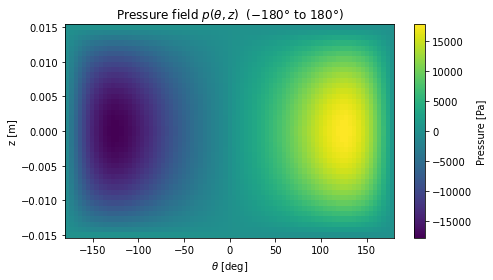

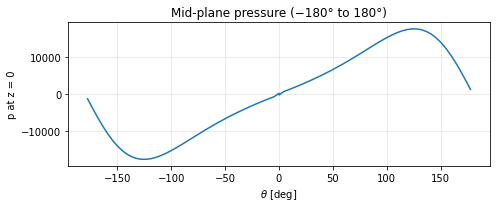

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# ---------------------------------------------------------
# Bearing / fluid parameters
# ---------------------------------------------------------
mu    = viscosity    # viscosity [Pa·s]
omega = -speed_rad    # angular speed [rad/s]

R  = diameter/2        # journal radius [m]  (D = 2R)
L  = length        # bearing length [m]
c  = clearance       # radial clearance [m]
eps = eps        # eccentricity ratio ε (0 <= ε < 1)

# ---------------------------------------------------------
# Domain in θ (circumferential) and z (axial)
# ---------------------------------------------------------
theta_min, theta_max = 0.0, 2.0 * np.pi
z_min, z_max         = -L / 2.0, L / 2.0

Ntheta, Nz = 80, 40  # grid resolution
theta = np.linspace(theta_min, theta_max, Ntheta)
z     = np.linspace(z_min, z_max, Nz)
dtheta = theta[1] - theta[0]
dz     = z[1] - z[0]

Theta, Z = np.meshgrid(theta, z, indexing="ij")  # Theta[i,j], Z[i,j]

# ---------------------------------------------------------
# Film thickness h(θ,z): classic journal, no axial variation
# h(θ) = c (1 + ε cos θ)
# ---------------------------------------------------------
h = c * (1.0 + eps * np.cos(Theta))

# ---------------------------------------------------------
# Coefficients Kθθ, Kzz (node-based)
#
# Reynolds eqn (in θ,z form):
# (1/R^2) ∂/∂θ (h^3 ∂p/∂θ) + ∂/∂z (h^3 ∂p/∂z) = 6 μ R ω ∂h/∂θ
#
# => Kθθ = h^3, Kzz = h^3, S = 6 μ R ω ∂h/∂θ
# ---------------------------------------------------------
Kth = h**3
Kzz = h**3

# Analytical derivative dh/dθ for h = c (1 + ε cos θ)
dh_dtheta = -c * eps * np.sin(Theta)

# Source term
S = 6.0 * mu * R * omega * dh_dtheta

# ---------------------------------------------------------
# Finite-difference discretisation of:
#
# (1/R^2) ∂/∂θ (Kth ∂p/∂θ) + ∂/∂z (Kzz ∂p/∂z) = S
#
# BCs:
# - Periodic in θ
# - Dirichlet p = 0 at z = ±L/2
#
# Unknowns: all θ nodes, interior z nodes j = 1..Nz-2
# ---------------------------------------------------------
def idx(i, j):
    """
    Map 2D indices (i,j) -> 1D index in [0, N_unknowns)
    i: 0..Ntheta-1 (theta index)
    j: 1..Nz-2      (z index, interior)
    """
    return i * (Nz - 2) + (j - 1)

N_unknowns = Ntheta * (Nz - 2)
A = lil_matrix((N_unknowns, N_unknowns))
b = np.zeros(N_unknowns)

# Precompute Kth, Kzz on cell faces for fluxes (central averaging)
# Periodic in θ for faces:
Kth_iphalf = np.zeros((Ntheta, Nz))      # θ faces (i+1/2, j)
for i in range(Ntheta):
    ip = (i + 1) % Ntheta
    Kth_iphalf[i, :] = 0.5 * (Kth[i, :] + Kth[ip, :])

# z-faces (i, j+1/2) and (i, j-1/2)
Kzz_jphalf = 0.5 * (Kzz[:, 1:] + Kzz[:, :-1])   # shape (Ntheta, Nz-1)

for i in range(Ntheta):
    for j in range(1, Nz - 1):  # interior in z
        row = idx(i, j)

        ip = (i + 1) % Ntheta   # periodic neighbors in θ
        im = (i - 1) % Ntheta

        # Coefficients at faces around (i,j)
        Kth_e = Kth_iphalf[i, j]     # east face  (i+1/2, j)
        Kth_w = Kth_iphalf[im, j]    # west face  (i-1/2, j)
        Kzz_n = Kzz_jphalf[i, j]     # north face (i, j+1/2)
        Kzz_s = Kzz_jphalf[i, j-1]   # south face (i, j-1/2)

        # Diagonal coefficient
        diag = (Kth_e + Kth_w) / (R**2 * dtheta**2) + (Kzz_n + Kzz_s) / dz**2
        A[row, row] = diag

        # θ-direction neighbors (always interior because periodic)
        A[row, idx(ip, j)] = -Kth_e / (R**2 * dtheta**2)
        A[row, idx(im, j)] = -Kth_w / (R**2 * dtheta**2)

        # z-direction neighbors
        # North (i, j+1) if interior
        if j + 1 <= Nz - 2:
            A[row, idx(i, j + 1)] = -Kzz_n / dz**2
        # If j+1 is the top boundary (j+1 == Nz-1), p=0 → contributes nothing

        # South (i, j-1) if interior
        if j - 1 >= 1:
            A[row, idx(i, j - 1)] = -Kzz_s / dz**2
        # If j-1 is the bottom boundary (j-1 == 0), p=0 → contributes nothing

        # Right-hand side: S(i,j)
        b[row] = S[i, j]

# ---------------------------------------------------------
# Solve the linear system A p = b
# ---------------------------------------------------------
A_csr = A.tocsr()
p_inner = spsolve(A_csr, b)

# Map solution back to full (Ntheta,Nz) grid with p=0 at z-boundaries
p = np.zeros((Ntheta, Nz))
for i in range(Ntheta):
    for j in range(1, Nz - 1):
        p[i, j] = p_inner[idx(i, j)]

# ---------------------------------------------------------
# Visualization
# ---------------------------------------------------------

# 2D colormap in θ–z
# Convert θ to degrees
Theta_deg = np.degrees(Theta)

# Shift from [0, 360] → [-180, 180]
Theta_deg_shifted = Theta_deg.copy()
Theta_deg_shifted[Theta_deg_shifted > 180] -= 360

# Sort along θ so plot is ordered correctly
sort_idx = np.argsort(Theta_deg_shifted[:, 0])
Theta_plot = Theta_deg_shifted[sort_idx, :]
Z_plot = Z[sort_idx, :]
p_plot = p[sort_idx, :]

# 2D pressure field plot
fig, ax = plt.subplots(figsize=(7, 4))
cf = ax.pcolormesh(Theta_plot, Z_plot, p_plot, shading="auto")
ax.set_xlabel(r"$\theta$ [deg]")
ax.set_ylabel("z [m]")
ax.set_title("Pressure field $p(\\theta, z)$  (−180° to 180°)")
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label("Pressure [Pa]")
plt.tight_layout()

# ---------------------------------------------------------
# 1D mid-plane plot (z ≈ 0)
# ---------------------------------------------------------
j_mid = np.argmin(np.abs(z - 0.0))
p_mid = p_plot[:, j_mid]

fig2, ax2 = plt.subplots(figsize=(7, 3))
ax2.plot(Theta_plot[:, 0], p_mid, "-")
ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel("p at z = 0")
ax2.set_title("Mid-plane pressure (−180° to 180°)")
ax2.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [13]:
print(h)
print(Theta)

[[0.00012663 0.00012663 0.00012663 ... 0.00012663 0.00012663 0.00012663]
 [0.00012655 0.00012655 0.00012655 ... 0.00012655 0.00012655 0.00012655]
 [0.00012629 0.00012629 0.00012629 ... 0.00012629 0.00012629 0.00012629]
 ...
 [0.00012629 0.00012629 0.00012629 ... 0.00012629 0.00012629 0.00012629]
 [0.00012655 0.00012655 0.00012655 ... 0.00012655 0.00012655 0.00012655]
 [0.00012663 0.00012663 0.00012663 ... 0.00012663 0.00012663 0.00012663]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.07953399 0.07953399 0.07953399 ... 0.07953399 0.07953399 0.07953399]
 [0.15906798 0.15906798 0.15906798 ... 0.15906798 0.15906798 0.15906798]
 ...
 [6.12411732 6.12411732 6.12411732 ... 6.12411732 6.12411732 6.12411732]
 [6.20365132 6.20365132 6.20365132 ... 6.20365132 6.20365132 6.20365132]
 [6.28318531 6.28318531 6.28318531 ... 6.28318531 6.28318531 6.28318531]]


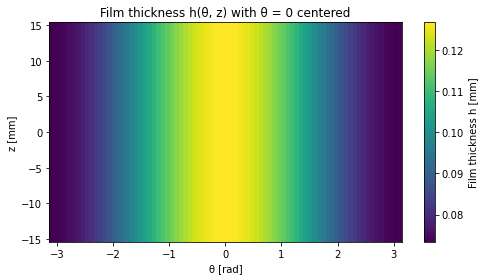

In [29]:
# Convert Theta from [0, 2π] to [-π, π]
Theta_shifted = Theta.copy()
Theta_shifted[Theta_shifted > np.pi] -= 2*np.pi

# Sort along θ so the plot is continuous
sort_idx = np.argsort(Theta_shifted[:, 0])

Theta_plot = Theta_shifted[sort_idx, :]
Z_plot = Z[sort_idx, :]
h_plot = h[sort_idx, :]

# Plot


plt.figure(figsize=(7, 4))
plt.pcolormesh(Theta_plot, Z_plot*1000, h_plot*1000, shading="auto")
plt.colorbar(label="Film thickness h [mm]")
plt.xlabel("θ [rad]")
plt.ylabel("z [mm]")
plt.title("Film thickness h(θ, z) with θ = 0 centered")
plt.tight_layout()
plt.show()